In [ ]:
# Written by David Schneidinger. Please modify as needed. Email me dschneidinger@g.ucla.edu if you have any questions
import numpy as np
import matplotlib.pyplot as plt
import osiris_utils as ou
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import plasmapy
import astropy

# If figures are for publication/presentation purposes, set the font to be something nice
plt.rcParams['font.size'] = 24

In [3]:
# Osiris utils seems to be a pretty useful package for stuff like this. Let's walk through some functionality
# To begin, we can give it a specific input deck and corresponding simulation data, which can be accessed
# from the high level `osiris_utils.Simulation` object

simulation_folder = "/pscratch/sd/d/dschnei/perlmutter_2.3.2d/perlmutter_2d.2d" # Modify as needed
sim = ou.Simulation(input_deck_path=simulation_folder)
print(f"Simulation: {sim}")
print(sim.__dict__.keys())
print(f"Species are: {sim.species}")

# We can also use the InputdeckIO object to minimize back and forth and errors.
# Especially useful for our simulations where we are playing around with mass ratios
deck = ou.InputDeckIO(filename = simulation_folder)
print(deck.species)

Simulation: <osiris_utils.data.simulation.Simulation object at 0x7ff5e50a5be0>
dict_keys(['_input_deck_path', '_input_deck', '_species', '_simulation_folder', '_diagnostics', '_species_handler'])
Species are: ['e', 'al', 'si']
{'e': Species(name=e, rqm=-1.0, q=-1.0, m=1.0), 'al': Species(name=al, rqm=72.0, q=1.0, m=72.0), 'si': Species(name=si, rqm=38.0, q=1.0, m=38.0)}


In [4]:
sim['b1-savg'].time(10)

[1910.5043999999998, '1 / \\omega_p']

# Calculate some relevant plasma quantities (hopefully in a generalized way)

In [5]:
# This appears to be the cell from hell. Takes forever to run...

ion_rqm = deck.species['al'].rqm
print(f"ion rqm: {ion_rqm}")
ion_inertial_length = np.sqrt(ion_rqm)
print(f"ion inertial length: {np.round(ion_inertial_length,2)} c/wpe")


# To calculate the Alfven velocity, we need to sample an approximate "background magnetic field" value.
# Alternatively, since it has a loose dependence on density, why don't we just calculate it in a 2D grid
# vA = B/np.sqrt(4 * np.pi * n_i * m_i)
# vA = sim['b1-savg'] / np.sqrt(4 * np.pi * (sim['al']['charge'] * deck.species['al'].rqm + sim['si']['charge']* deck.species['si'].rqm))
# Alfven_speed = sim.add_diagnostic(vA, "vA")

# Calculate the gyrofrequency
# We know B0 to be 75,000 G, but we need to normalize it to OSIRIS units.
# Calculate plasma frequency
n0 = 5e18 * astropy.units.cm**-3
wpe = plasmapy.formulary.frequencies.plasma_frequency(n0, particle="e-") / (astropy.units.rad)
print(f"wpe: {wpe}")

ion_rqm_real = 1836 * 27.0 / 6
ion_inertial_length_real = 2.28e7 * np.sqrt(ion_rqm_real / n0).value
print(f"ion inertial length (real): {np.round(ion_inertial_length_real,2)} cm")

electron_inertial_length_real = 5.31e5 * np.sqrt(1 / n0).value
print(f"electron inertial length (real): {np.round(electron_inertial_length_real,2)} cm")
# Real magnetic field value
B_real = 75000 * astropy.units.Gauss

B_norm = (astropy.constants.m_e * wpe / astropy.constants.e.si).to(astropy.units.Gauss)
print(f"B_norm: {B_norm}")

# Normalized magnetic field in OSIRIS units (dimensionless)
B_osiris = (B_real / B_norm).to(astropy.units.dimensionless_unscaled)
# B_osiris = .07
print(f"B_osiris (normalized): {B_osiris}")

# double check answer
B_real_check = B_osiris * 3.204e-3 * np.sqrt(n0)
print(f"B_real_check: {B_real_check.value}")
# Triple check answer
B_real_check =  5.681e-8 * B_osiris * wpe
print(f"B_real_check (triple check): {B_real_check.value}")
# Ion gyrofrequency: omega_ci = q_i * B / m_i = (q_i / m_i) * B
# In OSIRIS units: omega_ci / wpe = (1 / rqm) * B_osiris (where rqm = m_i/m_e)
omega_ci = B_osiris / ion_rqm
print(f"omega_ci: {omega_ci} wpe")
# Find omega_ci in physical units (Hz)
Z = 6
omega_ci_real = Z * astropy.constants.e.si * B_real / (astropy.constants.m_p * 27)
print(f"1/omega_ci (s): {(1/omega_ci_real).to(astropy.units.s)}")


vA_osiris = B_osiris / np.sqrt(deck.species['al'].rqm)

ion rqm: 72.0
ion inertial length: 8.49 c/wpe
wpe: 126146885692815.61 1 / s
ion inertial length (real): 0.93 cm
electron inertial length (real): 0.0 cm
B_norm: 7172245.307661366 G
B_osiris (normalized): 0.010456976411540928
B_real_check: 74917.56234539673
B_real_check (triple check): 74938.92360897495
omega_ci: 0.000145235783493624 wpe
1/omega_ci (s): 6.263810948911892e-09 s


In [6]:
# Some more practice, let's get the x and y bounds
deck.sections;
print(deck.sections[5])
xmin, ymin = [int(num) for num in deck.sections[5][1]['xmin(1:2)'].split(',')]
xmax, ymax = [int(num) for num in deck.sections[5][1]['xmax(1:2)'].split(',')]

print(f"(xmin, xmax): {xmin, xmax}, (ymin, ymax): {ymin, ymax}")
# This is definitely the worst way of doing this

['space', {'xmin(1:2)': '-1500,350', 'xmax(1:2)': '1500,3000'}]
(xmin, xmax): (-1500, 1500), (ymin, ymax): (350, 3000)


# Let's start by generating some rudimentary plots from the simulation

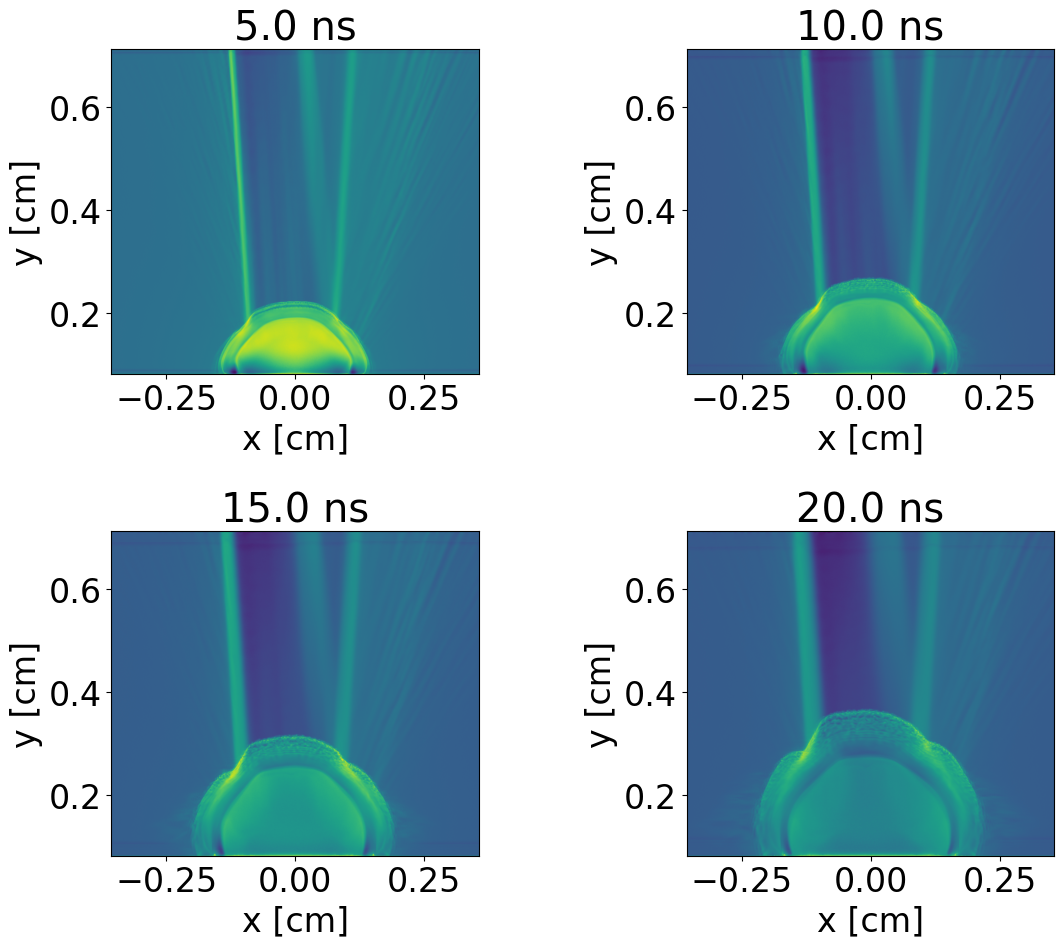

In [7]:
# At t = 0, things should look pretty identical to how they are initialized from FLASH
def plot_with_zoom(data, t, xmin_zoom, xmax_zoom, ymin_zoom, ymax_zoom, zoom = True):
    # Create figure and main axes
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(np.log(-1*data[t].T), origin='lower', extent=[xmin *electron_inertial_length_real, xmax * electron_inertial_length_real, 
                                                        ymin * electron_inertial_length_real, ymax * electron_inertial_length_real],)
                #    vmax=np.max(np.log(data[t]))/1.5)
    ax.set_xlabel(r"x [cm]")
    ax.set_ylabel(r"y [cm]")
    plt.title(rf"${data.name}$" + f", t = {np.round((data.time(t)[0] * omega_ci /omega_ci_real).to(astropy.units.ns).value, 3)} ns")
    # plt.title(f"t = {round(data.time(t)[0] * omega_ci,0)}" + r"$\Omega_{ci}$")
    if zoom:
        # Create inset axes (adjust position and size as needed)
        # Parameters: [width%, height%, location] where location can be 1-4 or 'upper right', 'lower left', etc.
        axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
        
        # Plot the same data in the inset
        axins.imshow(np.log(-1 * data[t].T), origin='lower', extent=[xmin * electron_inertial_length_real, xmax * electron_inertial_length_real,
                                                        ymin *electron_inertial_length_real, ymax * electron_inertial_length_real])
        
        # Set the zoom region (adjust these values to your region of interest)
        x1, x2 = xmin_zoom, xmax_zoom  # zoom to left half
        y1, y2 = ymin_zoom, ymax_zoom  # zoom to bottom half
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        
        # Optional: mark the inset region on the main plot with a rectangle and connecting lines
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="white", lw=1.5, linestyle='--')
        axins.set_xticks([])
        axins.set_yticks([])
    
    # plt.tight_layout()
    plt.show()
times = [30, 60, 87, 116]
data = sim['e']['charge']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, t in zip(axes.flat, times):
    im = ax.imshow(
        np.log(-1 * data[t].T),
        origin='lower',
        extent=[
            xmin * electron_inertial_length_real,
            xmax * electron_inertial_length_real,
            ymin * electron_inertial_length_real,
            ymax * electron_inertial_length_real,
        ],
    )
    ax.set_title(
        f"{np.round((data.time(t)[0] * omega_ci / omega_ci_real).to(astropy.units.ns).value, 0)} ns"
    )
    ax.set_xlabel(r"x [cm]")
    ax.set_ylabel(r"y [cm]")

plt.tight_layout()
# plt.suptitle("electron charge density")
plt.show()


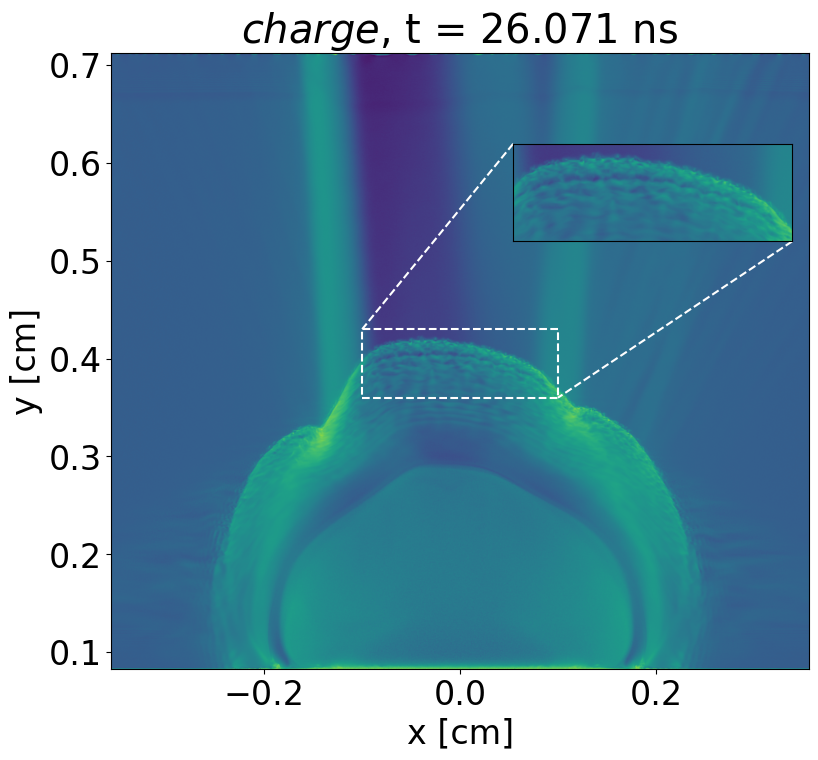

In [8]:
plot_with_zoom(sim['e']['charge'], t=150, xmin_zoom=-0.1, xmax_zoom=0.1, ymin_zoom = .36, ymax_zoom=.43, zoom=True)

In [9]:
# Load one of the high-res simulations where I made the phase space right.
simulation_folder = "/pscratch/sd/d/dschnei/perlmutter_2.7.2d/perlmutter_2d.2d" # Modify as needed
sim = ou.Simulation(input_deck_path=simulation_folder)
print(f"Simulation: {sim}")
print(sim.__dict__.keys())
print(f"Species are: {sim.species}")
deck = ou.InputDeckIO(filename = simulation_folder)
print(deck.species)
from osiris_utils.data.diagnostic import which_quantities
print(which_quantities())

Simulation: <osiris_utils.data.simulation.Simulation object at 0x7ff5e4bba210>
dict_keys(['_input_deck_path', '_input_deck', '_species', '_simulation_folder', '_diagnostics', '_species_handler'])
Species are: ['e', 'al', 'si']
{'e': Species(name=e, rqm=-1.0, q=-1.0, m=1.0), 'al': Species(name=al, rqm=145.0, q=1.0, m=145.0), 'si': Species(name=si, rqm=77.0, q=1.0, m=77.0)}
Available quantities:
['n', 'charge', 'q1', 'q2', 'q3', 'j1', 'j2', 'j3', 'vfl1', 'vfl2', 'vfl3', 'ufl1', 'ufl2', 'ufl3', 'P11', 'P12', 'P13', 'P22', 'P23', 'P33', 'T11', 'T12', 'T13', 'T22', 'T23', 'T33', 'e1', 'e2', 'e3', 'b1', 'b2', 'b3', 'e1-savg', 'e2-savg', 'e3-savg', 'b1-savg', 'b2-savg', 'b3-savg', 'part_e1', 'part_e2', 'part_e3', 'part_b1', 'part_b2', 'part_b3', 'ext_e1', 'ext_e2', 'ext_e3', 'ext_b1', 'ext_b2', 'ext_b3', 'p1x1', 'p1x2', 'p1x1x2', 'p2x1x2', 'p1x3', 'p2x1', 'p2x2', 'p2x3', 'p3x1', 'p3x2', 'p3x3', 'gammax1', 'gammax2', 'gammax3']
None


In [14]:
p1x1x2 = sim['al']['p1x1x2'][0][:,8,:]

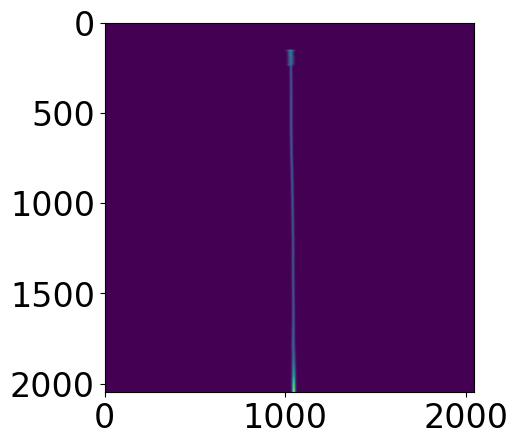

In [15]:
plt.imshow(p1x1x2)